# Module QTL Replication

**Created**: 26 May 2022

## Environment

In [1]:
if (!requireNamespace("lme4")) {
    install.packages("lme4")
}

if (!requireNamespace("SummarizedExperiment")) {
    BiocManager::install("SummarizedExperiment")
}

Loading required namespace: lme4

Loading required namespace: SummarizedExperiment



In [2]:
library(tidyverse)
library(SummarizedExperiment)
library(data.table)
library(lme4)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCumm

## Load Data

In [3]:
exp.micro <- readRDS("~/gains_team282/nikhil/data/GAinS_Microarray/gains_full_microarray_dedup_norm_combat_average-per-gene.rds")

In [4]:
head(assays(exp.micro)[[1]])

,UK01310070_1,GAUKRV022000_5,UK50240006_1,UK17630075_5,UK47500001_1,UK02450065_1,UK42510085_3,UK55900005_5,UK17120090_1,UK02960147_1,⋯,UK59590022_1,UK59920018_3,UK54590015_3,UK59590022_5,UK59920018_5,UK59600016_1,UK54590015_5,UK59920018_1,UK59590022_3,UK54590015_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR2B,5.070486,6.653960,4.663940,6.298904,5.792164,5.541233,6.589237,5.720120,5.470666,5.592083,⋯,5.440747,5.247173,5.841708,6.020871,5.809683,5.549477,6.085626,5.202223,5.883180,6.305140
TRIM44,7.117554,7.382045,7.534112,7.880084,7.209191,7.392303,7.624026,7.279305,5.998695,6.929052,⋯,6.807849,7.161457,7.750011,7.572399,7.063671,6.739109,7.480136,6.262286,7.095712,7.259652
LOC653895,4.475777,5.351038,3.361656,5.020616,4.822896,3.857210,4.136880,4.255974,5.576264,4.733030,⋯,4.287172,4.237207,4.547339,4.431565,4.973591,4.236186,4.746736,5.381066,4.353878,4.892271
HS.133181,6.253662,7.183581,5.653099,6.025659,6.384615,6.473308,5.684193,5.248252,7.001745,5.875798,⋯,6.261055,6.847974,7.695799,7.211885,6.723676,5.671851,7.096209,5.936946,6.946404,7.033030
C15ORF39,8.759778,10.013569,9.007721,10.406369,10.657716,8.823518,10.285644,9.318283,10.744836,9.166786,⋯,9.749185,9.944847,9.625208,9.989105,9.412967,8.202531,9.552910,8.763919,10.442625,10.045854
PCDHGA9,3.837391,5.109705,4.255341,5.173701,5.368823,5.127123,3.671405,5.065489,5.142512,4.809263,⋯,3.914645,4.789458,4.427052,4.237400,4.464034,4.770707,4.570826,5.177364,4.443761,4.311195


In [5]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")

In [6]:
head(modules)

,Gene,Module
,<chr>,<chr>
1,ENSG00000001167,Module_1
2,ENSG00000002330,Module_1
3,ENSG00000002822,Module_1
4,ENSG00000005175,Module_1
5,ENSG00000005194,Module_1
6,ENSG00000005893,Module_1


In [7]:
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.multiple.csv", row.names=1)

In [8]:
head(eigengenes)

,ME_1_1,ME_1_2,ME_1_3,ME_1_4,ME_1_5,ME_2_1,ME_2_2,ME_2_3,ME_2_4,ME_2_5,⋯,ME_105_1,ME_105_2,ME_105_3,ME_105_4,ME_105_5,ME_106_1,ME_106_2,ME_106_3,ME_106_4,ME_106_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UK02270173_3,0.008640296,-0.04165815,0.027430556,-0.020437463,0.018138657,0.007926439,-0.03881513,0.03058366,-0.014329184,0.009126178,⋯,0.033258706,0.010337824,0.031572946,0.0308363822,-0.01556043,-0.003317747,0.01850385,0.001776021,0.034254655,0.002439359
UK15130120_3,-0.037073495,-0.01795641,-0.007283072,-0.026494085,0.003339612,-0.033179470,-0.01991901,-0.01688432,-0.014852805,0.049310271,⋯,0.051184001,-0.001611603,0.005624913,0.0273538940,-0.03670228,-0.012327128,0.04405671,0.013144923,0.017987682,-0.001779326
UK58000006_3,0.029670524,-0.03481715,0.028491140,-0.009483861,-0.005862293,0.021490110,-0.03480085,0.03014656,-0.003961906,-0.032946862,⋯,-0.006622840,-0.045791646,0.033491934,-0.0420056572,0.02749077,-0.004740631,0.04638229,-0.043309799,0.028730908,-0.024051766
UK47010004_3,0.011954974,0.01091971,0.038665347,0.003726632,0.052019153,0.007360515,0.01763746,0.03490663,-0.005573984,-0.016190548,⋯,-0.003072117,-0.010005728,0.019263388,0.0009626484,0.06116524,0.012014706,0.01637633,-0.003045472,-0.018223178,-0.020637855
UK42020088_5,0.009818957,0.02100233,-0.019852180,-0.013052613,-0.030223051,0.008322535,0.01712902,-0.02394729,0.003193689,0.019716419,⋯,-0.032697222,-0.001257679,-0.019760950,-0.0079000979,0.02988006,0.007915598,-0.01649680,0.013250580,-0.031445321,-0.014168970
UK47490007_3,-0.021930377,0.03807246,0.042329128,-0.025160071,0.012732846,-0.024756322,0.03899339,0.03987212,-0.030754242,0.038550679,⋯,-0.003607270,0.043079589,0.025888343,0.0413386960,0.04360340,0.024871961,-0.03349057,0.029665102,-0.009251542,-0.052908888


In [9]:
load("~/gains_team282/eqtl/peer/microarray/PEER_factors_covs_norm_cells_641_microarray.Rda")

In [10]:
colnames(factors) <- c(colnames(covs), "Dummy", paste0("PEER", 1:30))
rownames(factors) <- gsub("^GA", "", rownames(covs))

In [11]:
geno <- fread("~/gains_team282/nikhil/data/genotypes/eigengene_sva_rep_genotypes.raw", drop=2:6) %>%
    as.data.frame()

rownames(geno) <- gsub("^GA", "", geno$FID)
geno$FID <- NULL

colnames(geno) <- gsub("_.$", "", colnames(geno))

In [12]:
head(geno)

,rs228669,rs79314241,rs106968,rs161803,rs12564367,rs10864320,rs3818762,rs13306556,rs45553335,rs45603435,⋯,rs844824,rs844832,rs844878,rs844881,rs1331286,rs227619,rs227628,rs227646,rs6132775,rs8125909
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
UKAR005000,0,0,0,0,0,0,1,1,2,2,⋯,0,0,0,0,0,0,0,0,0,0
UKAR024000,0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
UKAR025000,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
UKAR027000,0,0,0,0,0,0,2,2,2,2,⋯,0,0,0,0,0,0,0,0,0,0
UKJR005000,0,0,0,0,0,0,1,1,1,1,⋯,0,0,0,0,2,2,2,2,2,2
UKJR010000,0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [13]:
mqtl <- read.csv("~/gains_team282/nikhil/expression/eigengene_sva/all_mqtl.csv")
mqtl.loci <- read.table("~/gains_team282/nikhil/expression/eigengene_sva/mqtl_full_summary_statistics_snps.txt", header=T)

In [14]:
lead.mqtl <- merge(mqtl, mqtl.loci, by.x=c("me", "snp"), by.y=c("ME", "SNP")) %>%
    dplyr::group_by(QTL.ID) %>%
    dplyr::slice_min(p, n=1)

## Compare Eigengenes

In [15]:
micro.eigens <- lapply(unique(modules$Module), function(module) {
    
    module.genes = modules$Gene[modules$Module == module]
    if (sum(rowData(exp.micro)$Ensembl_ID %in% module.genes) < 5) {
        return(NULL)
    }
    
    mod.exp = exp.micro[rowData(exp.micro)$Ensembl_ID %in% module.genes, ]
    
    module.svd = svd(scale(t(assays(mod.exp)[[1]])))
    module.top.eigens = module.svd$u[,1:5]
    rownames(module.top.eigens) = gsub("^GA", "", colData(mod.exp)$SampleID)
    colnames(module.top.eigens) = paste0(gsub("Module_", "Micro_ME_", module), "_", 1:5)
    
    return(module.top.eigens)
}) %>%
    do.call(cbind, .)

In [16]:
head(micro.eigens)

,Micro_ME_1_1,Micro_ME_1_2,Micro_ME_1_3,Micro_ME_1_4,Micro_ME_1_5,Micro_ME_10_1,Micro_ME_10_2,Micro_ME_10_3,Micro_ME_10_4,Micro_ME_10_5,⋯,Micro_ME_96_1,Micro_ME_96_2,Micro_ME_96_3,Micro_ME_96_4,Micro_ME_96_5,Micro_ME_99_1,Micro_ME_99_2,Micro_ME_99_3,Micro_ME_99_4,Micro_ME_99_5
UK01310070_1,-0.01601799,-0.045036070,0.034467430,0.093455033,0.008305606,-0.018423860,-0.001610685,-0.05198010,0.035228544,0.034562308,⋯,-0.097747466,0.005064751,-0.02663545,0.004831265,-0.045871560,0.01963915,-0.11480184,-0.024974804,-0.05162108,-0.009766825
UKRV022000_5,-0.01012309,0.019770385,-0.006289933,0.006196103,0.030872778,0.009753326,-0.003296697,-0.01233154,0.003876523,-0.081315122,⋯,-0.005253908,-0.021496752,0.03027550,-0.040747276,0.092884005,0.01153088,0.01062755,0.048802956,-0.09341334,0.004213724
UK50240006_1,0.02202818,-0.074226721,-0.009347810,0.026115699,0.039067097,-0.073912013,0.004154793,-0.04755903,-0.023185774,0.009168093,⋯,-0.044580742,-0.032422494,0.02309836,0.018227595,-0.001179965,-0.05427548,-0.03751932,-0.018849142,-0.02516148,-0.075463748
UK17630075_5,-0.03301611,0.025167987,0.024643276,-0.015425626,0.039606076,0.026276887,0.012127503,0.01601656,0.033877686,-0.019191657,⋯,0.001736140,0.041894991,0.01985971,-0.003649297,0.042067733,0.02056358,0.03352514,-0.003855768,0.02537017,0.012321898
UK47500001_1,-0.04898155,-0.009744342,-0.002948807,-0.052813702,0.037846641,0.019620111,0.046079463,0.02635130,-0.001966977,0.045065242,⋯,0.024518041,0.050908011,-0.03413770,0.006952725,-0.017734190,0.03011030,0.09287762,0.002582364,0.02498819,-0.042630748
UK02450065_1,-0.01580593,-0.052308289,-0.075350285,0.089011224,-0.076261752,-0.043209227,0.017610215,-0.07579444,-0.079287430,0.033779103,⋯,-0.031363764,-0.061186655,-0.01768211,0.059803190,-0.080999580,0.04932842,-0.13051822,-0.031960465,0.03027492,-0.028824468


How many modules could be recreated in the microarray data? This requires enough genes to be present in both cohorts. 95 of the 106 modules could be replicated across both cohorts.

In [17]:
rep.mes <- unique(gsub("_.$", "", gsub("Micro_ME_", "", colnames(micro.eigens))))
length(rep.mes)

[1] 95

Are the eigengenes well-correlated between microarray and RNA-seq? We can test this using the overlapping samples. Let's use these to test for correlation. I'm only going to attempt to replicate the mQTL from the first PC (the eigengene proper). Some correlate really well; others do not correlate well at all. This could be due to the fact that (1) not all genes are present on the microarray, (2) microarray counts are not absolute, or (3) due to the collapsing of values between multiple probe sets.

In [18]:
all.eigens = merge(micro.eigens, eigengenes, by=0)[, -1]

rhos <- sapply(rep.mes, function(me.n) {
    module.eigengene = all.eigens[, paste0("ME_", me.n, "_1")]
    module.micro.eigengene = all.eigens[, paste0("Micro_ME_", me.n, "_1")]
    cor(module.eigengene, module.micro.eigengene, method="spearman")
})

names(rhos) <- paste0("ME_", names(rhos))

In [19]:
design.mtx <- colData(exp.micro)[, c("GAinSID", "SampleID")]
rownames(design.mtx) <- gsub("^GA", "", rownames(design.mtx))
design.mtx$GAinSID <- gsub("^GA", "", design.mtx$GAinSID)
design.mtx$SampleID <- gsub("^GA", "", design.mtx$SampleID)

design.mtx <- merge(design.mtx, micro.eigens, by.x="SampleID", by.y=0) %>%
    merge(., geno, by.x="GAinSID", by.y=0) %>%
    merge(., factors, by.x="SampleID", by.y=0) %>%
    dplyr::filter(!(SampleID %in% rownames(eigengenes)))

covs = c(
    c("SRS", "Diagnosis", "Neutrophils", "Lymphocytes", "Monocytes"),
    paste0("PEER", 1:20), paste0("PC", 1:7)
)

mqtl.reps <- do.call(rbind, lapply(1:nrow(lead.mqtl), function(i) {
    
    snp = as.character(lead.mqtl[i, "snp"])
    
    if (!(snp %in% colnames(geno))) {
        return(NULL)
    }
    
    module = gsub("ME_", "Module_", lead.mqtl[i, "me"])
    me = paste0(gsub("Module_", "Micro_ME_", module), "_1")
    
    if (!(me %in% colnames(design.mtx))) {
        return(NULL)
    }

    variant.design <- design.mtx[,c(me, snp, covs, "GAinSID")]

    f.null <- as.formula(paste0(me, "~", paste0(covs, collapse="+"), "+(1|GAinSID)"))
    model.null <- lmer(f.null, data=variant.design, REML=FALSE)

    f.alt <- as.formula(paste0(me, "~`", snp , "`+", paste0(covs, collapse="+"), "+(1|GAinSID)"))
    model.test <- lmer(f.alt, data=variant.design, REML=FALSE)

    if (!all(complete.cases(variant.design[, snp]))) {
        model.null <- update(model.null, subset=complete.cases(variant.design[, snp]))
        model.test <- update(model.test, subset=complete.cases(variant.design[, snp]))
    }

    data.frame(matrix(
        data=c(
            me, snp,
            summary(model.test)$coefficients[snp, ],
            anova(model.null, model.test)["model.test", "Pr(>Chisq)"]
        ),
        nrow=1, ncol=6
    ))
})) %>%
    as.data.frame() %>%
    dplyr::select(me=1, snp=2, beta=3, se=4, t=5, p=6) %>%
    dplyr::mutate(beta=as.numeric(beta), se=as.numeric(se), t=as.numeric(t), p=as.numeric(p))

Of the 31 lead mQTL, only 26 were at MAF > 0.01 in the microarray cohort and had enough genes to generate a module.

In [20]:
rep.res <- lead.mqtl %>%
    dplyr::ungroup() %>%
    dplyr::select(me, snp, beta.original=beta, se.original=se, me.original=me) %>%
    dplyr::mutate(me=paste0("Micro_", me.original, "_1")) %>%
    merge(., mqtl.reps, by=c("me", "snp")) %>%
    dplyr::mutate(rho=rhos[me.original]) %>%
    dplyr::mutate(p=p.adjust(p, method="BH")) %>%
    dplyr::mutate(significant=p < 0.05) %>%
    dplyr::mutate(matching=sign(beta.original) * sign(rho) == sign(beta))

head(rep.res)

,me,snp,me.original,beta.original,se.original,beta,se,t,p,rho,significant,matching
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
1,Micro_ME_101_1,rs1131017,ME_101,-0.01218272,0.0010177908,0.049417631,0.0009695625,50.968999,1.813217e-164,-0.4277884,TRUE,TRUE
2,Micro_ME_101_1,rs582717,ME_101,0.01339385,0.0010127331,0.001648781,0.0027003966,0.610570,6.122097e-01,-0.4277884,FALSE,FALSE
3,Micro_ME_102_1,rs629329,ME_102,0.02986714,0.0014708263,0.019114857,0.0021635185,8.835079,2.456743e-16,0.3847454,TRUE,TRUE
4,Micro_ME_104_1,rs36053285,ME_104,-0.02768647,0.0009773132,-0.008005557,0.0018946560,-4.225335,6.110302e-05,0.5199441,TRUE,TRUE
5,Micro_ME_105_1,rs1757183,ME_105,0.01991662,0.0009674236,-0.004865838,0.0016177458,-3.007789,4.805397e-03,0.3556179,TRUE,FALSE
6,Micro_ME_106_1,rs7395319,ME_106,-0.01778240,0.0011140475,0.006384105,0.0020294774,3.145689,3.499302e-03,-0.7578623,TRUE,TRUE


In [21]:
nrow(rep.res)

[1] 26

The median correlation between matched samples for the eigengenes was higher in the module QTL that returned as significant replicates.

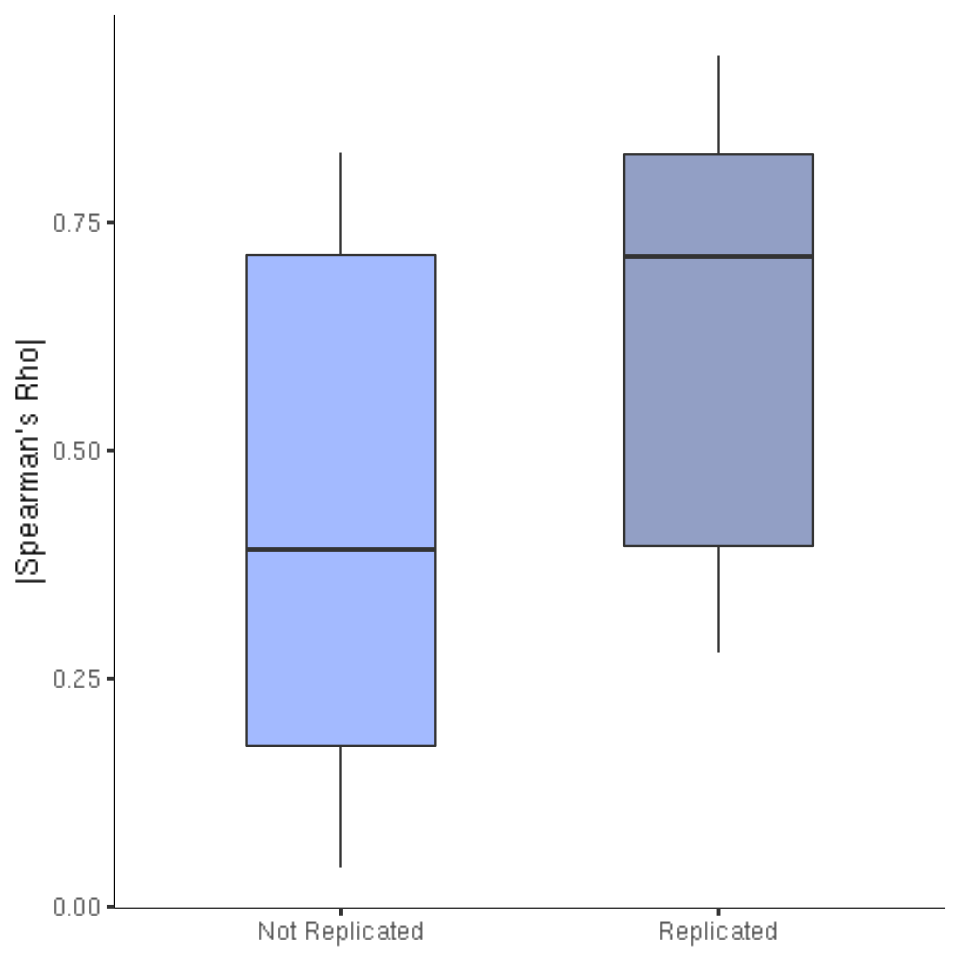

In [22]:
options(repr.plot.width=8, repr.plot.height=8)

rep.res %>%
    dplyr::mutate(significant=ifelse(significant & matching, "Replicated", "Not Replicated")) %>%
    ggplot() +
    geom_boxplot(aes(x=significant, y=abs(rho), fill=significant), width=0.5, alpha=0.5) +
    scale_fill_manual(values=c("royalblue1", "royalblue4")) +
    guides(fill="none") +
    ylab("|Spearman's Rho|") +
    ggplot_theme +
    theme(axis.title.x=element_blank())

ggsave("04_Expression/results/mqtl_replication_rho.svg", width=8, height=8)

In [23]:
wilcox.test(abs(rep.res$rho[rep.res$significant]), abs(rep.res$rho[!rep.res$significant]), exact=F)


	Wilcoxon rank sum test with continuity correction

data:  abs(rep.res$rho[rep.res$significant]) and abs(rep.res$rho[!rep.res$significant])
W = 106.5, p-value = 0.1118
alternative hypothesis: true location shift is not equal to 0


17 of the 26 mQTL that could be tested were significant in the replication cohort. Of those 17, 14 had matching directions of effect based on the correlation between matching samples for the eigengen.

In [24]:
sum(rep.res$significant)

[1] 17

In [25]:
sum(rep.res$matching[rep.res$significant])

[1] 14

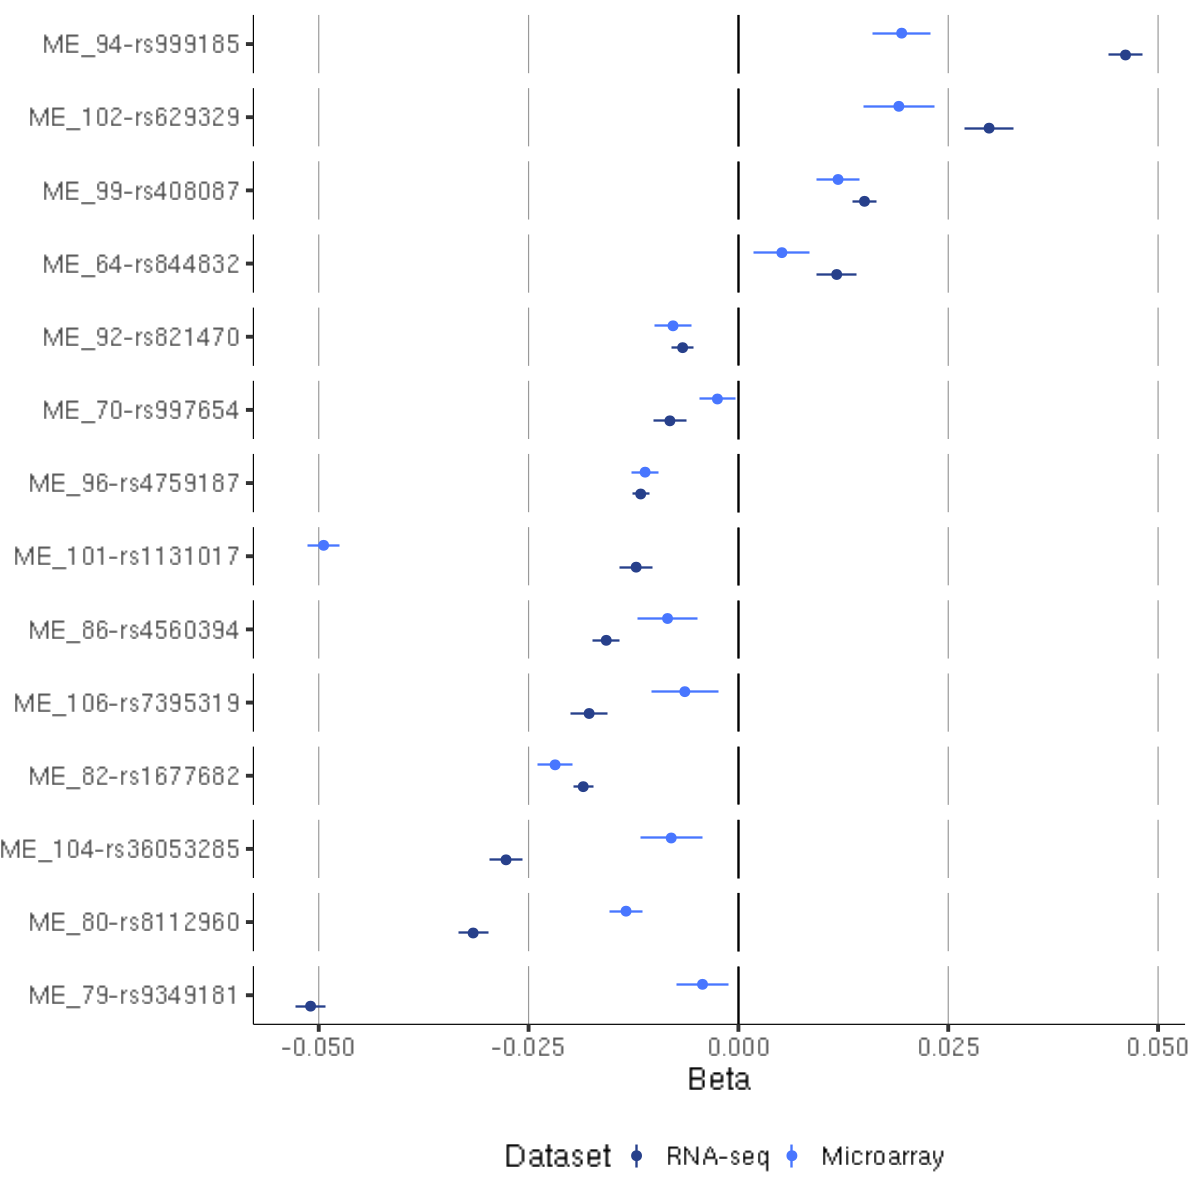

In [26]:
options(repr.plot.width=10, repr.plot.height=10)

rep.res %>%
    dplyr::filter(significant, matching) %>%
    dplyr::mutate(me.snp=paste0(me.original, "-", snp)) %>%
    dplyr::mutate(beta=beta * sign(rho)) %>%
    dplyr::select(me.snp, beta.original, se.original, beta, se) %>%
    dplyr::arrange(desc(beta.original)) %>%
    dplyr::mutate(me.snp=factor(me.snp, levels=me.snp)) %>%
    tidyr::pivot_longer(!me.snp, names_to="col.name") %>%
    dplyr::mutate(statistic=gsub("\\..*", "", col.name)) %>%
    dplyr::mutate(dataset=ifelse(grepl("original", col.name), "RNA-seq", "Microarray")) %>%
    dplyr::select(me.snp, statistic, value, dataset) %>%
    tidyr::pivot_wider(names_from=statistic, values_from=value) %>%
    dplyr::mutate(dataset=factor(dataset, levels=c("RNA-seq", "Microarray"))) %>%
    dplyr::mutate(beta.low=beta-(1.96 * se), beta.high=beta+(1.96*se)) %>%
    ggplot() +
    geom_hline(aes(yintercept=0)) +
    geom_point(aes(x=me.snp, y=beta, color=dataset), position=position_dodge(0.9), size=I(2)) +
    geom_linerange(aes(x=me.snp, ymin=beta.low, ymax=beta.high, color=dataset), position=position_dodge(0.9)) +
    scale_color_manual("Dataset", values=c("royalblue4", "royalblue1")) +
    facet_grid(me.snp ~ ., scales="free_y") +
    coord_flip() +
    ylab("Beta") +
    ggplot_theme +
    theme(
        strip.background.y=element_blank(), strip.text.y=element_blank(),
        axis.title.y=element_blank(),
        panel.grid.major.x=element_line(size=0.25, color="gray60")
    )

ggsave("04_Expression/results/mqtl_replication_beta.svg", width=10, height=10)